In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys

import glob

# Precinct Shapefile
---

## VEST's Documentation File

Election results from Wyoming Secretary of State (https://soswy.state.wy.us/Elections/ElectionResults.aspx)
Precinct shapefile primarily from the U.S. Census Bureau's 2020 Redistricting Data Program final release. The Fremont County shapefile was provided by the Fremont County Assessor.
 
The following modifications were made to recreate the 2018 precinct boundaries.

Albany: Consolidate 8 county VTDs into 5 precincts, 18 city VTDs into 8 precincts \ 
Campbell: Align 1-27/24-1 with Gillette municipal boundary \
Carbon: Remove district splits for 1-2, 5-1, 6-1, 7-1, 11-2, 12-1, 13-1 \
Goshen: Align VTDs with legislative districts and 2012 redistricting map \
Laramie: Adjust 03-06, 03-07 to reverse Cheyenne annexations \
Platte: Merge Y-O Ranch into Wheatland Rural \
Sheridan: Remove district splits for 01-01, 02-01, 02-03, 03-03, 11-03 \
Sweetwater: Align wards and precincts countywide with 2012 legislative redistricting \
Uinta: Remove 02-01 district split; Split 01-03/01-04; Merge 04-01/04-03 \
Weston: Adjust 5-2/5-3 boundary to match 2012 realignment

G18USSRBAR - John Barrasso (Republican Party) \
G18USSDTRA - Gary Trauner (Democratic Party) \
G18USSLPOR - Joseph Porambo (Libertarian Party) \
G18USSOWRI - Write-in Votes

G18HALRCHE - Liz Cheney (Republican Party) \
G18HALDHUN - Greg Hunter (Democratic Party) \
G18HALLBRU - Richard Brubaker (Libertarian Party) \
G18HALCCUM - Daniel Clyde Cummings (Constitution Party) \
G18HALOWRI - Write-in Votes

G18GOVRGOR - Mark Gordon (Republican Party) \
G18GOVDTHR - Mary A. Throne (Democratic Party) \
G18GOVLSTR - Lawrence Gerard Struempf (Libertarian Party) \
G18GOVCRAM - Rex "T-Rex" Rammell (Constitution Party) \
G18GOVOWRI - Write-in Votes

G18SOSRBUC - Edward Buchanan (Republican Party) \
G18SOSDBYR - James W. Byrd (Democratic Party) \
G18SOSLCAR - Kit Carson III (Libertarian Party) \
G18SOSOWRI - Write-in Votes

G18AUDRRAC - Kristi Racines (Republican Party) \
G18AUDDDOC - Jeff Dockter (Democratic Party) \
G18AUDOWRI - Write-in Votes

G18TRERMEI - Curt Meier (Republican Party) \
G18TREDLOW - Chris Lowry (Democratic Party) \
G18TREOWRI - Write-in Votes

G18SPIRBAL - Jillian Balow (Republican Party) \
G18SPIOWRI - Write-in Votes

### Load VEST's Final File

In [2]:
vest_shp = gp.read_file("./raw_from_source/VEST/wy_2018/wy_2018.shp")

In [3]:
vest_shp.shape

(483, 31)

In [4]:
vest_shp.head()

,STATEFP20,COUNTYFP20,VTDST20,NAME20,G18USSRBAR,G18USSDTRA,G18USSLPOR,G18USSOWRI,G18HALRCHE,G18HALDHUN,...,G18SOSOWRI,G18AUDRRAC,G18AUDDDOC,G18AUDOWRI,G18TRERMEI,G18TREDLOW,G18TREOWRI,G18SPIRBAL,G18SPIOWRI,geometry
0,56,045,000101,NEWCASTLE RURAL OUTSIDE,428,64,15,2,398,73,...,0,439,63,0,447,60,0,462,4,"MULTIPOLYGON (((-104.22316 43.85669, -104.2231..."
1,56,045,000102,Northwest,327,48,13,0,311,51,...,0,332,44,0,323,54,0,335,6,"POLYGON ((-104.55704 43.85906, -104.55691 43.8..."
2,56,045,000301,UPTON OUTSIDE,201,13,5,0,195,13,...,0,197,13,0,194,17,0,194,1,"POLYGON ((-105.08141 43.82696, -105.08139 43.8..."
3,56,045,000201,OSAGE,118,10,9,0,108,8,...,0,119,13,0,119,14,0,121,2,"POLYGON ((-104.59766 43.85787, -104.59762 43.8..."
4,56,045,000501,NEWCASTLE EAST,292,51,15,1,259,68,...,0,304,45,0,295,51,0,310,4,"POLYGON ((-104.20615 43.85409, -104.20606 43.8..."


<AxesSubplot:>

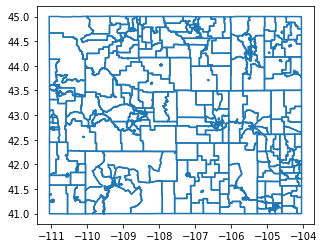

In [5]:
vest_shp.boundary.plot()

In [6]:
vest_shp.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'NAME20', 'G18USSRBAR',
       'G18USSDTRA', 'G18USSLPOR', 'G18USSOWRI', 'G18HALRCHE', 'G18HALDHUN',
       'G18HALLBRU', 'G18HALCCUM', 'G18HALOWRI', 'G18GOVRGOR', 'G18GOVDTHR',
       'G18GOVLSTR', 'G18GOVCRAM', 'G18GOVOWRI', 'G18SOSRBUC', 'G18SOSDBYR',
       'G18SOSLCAR', 'G18SOSOWRI', 'G18AUDRRAC', 'G18AUDDDOC', 'G18AUDOWRI',
       'G18TRERMEI', 'G18TREDLOW', 'G18TREOWRI', 'G18SPIRBAL', 'G18SPIOWRI',
       'geometry'],
      dtype='object')

# Election Results

## Load Files

The SOS directed to this link for election results for the 2018 general: https://soswy.state.wy.us/Elections/ElectionResults.aspx
